# Predizione di vittoria nelle battaglie di Pokémon

*Obiettivo:* Costruire e confrontare diversi modelli per predire il vincitore di un duello Pokémon.

### Partecipanti:
- Daniele Merighi
- Luca Palazzini
- Lore

---

## Table of Contents
1. [Parametri e Configurazione](#parametri-e-configurazione)
2. [Import delle Librerie](#import-delle-librerie)
3. [Caricamento e Unione dei Dati](#caricamento-e-unione-dei-dati)
4. [Esplorazione dei Dati](#esplorazione-dei-dati)
5. [Feature Engineering](#feature-engineering)
6. [Analisi delle Correlazioni](#analisi-delle-correlazioni)
7. [Addestramento e Tuning dei Modelli](#addestramento-e-tuning-dei-modelli)
8. [Valutazione dei Modelli](#valutazione-dei-modelli)

# Parametri e Configurazione <a id="parametri-e-configurazione"></a>

In [34]:
# Definizione dei percorsi e dei parametri globali
DATASET_BASE_PATH: str = './datasets'
COMBATS_PATH: str = f"{DATASET_BASE_PATH}/combats.csv"
TYPE_CHART_PATH: str = f"{DATASET_BASE_PATH}/type_chart.csv"
POKEMON_PATH: str = f"{DATASET_BASE_PATH}/pokemon.csv"
MODEL_DIR: str = './models'
RANDOM_STATE: int = 42
# Dimensioni dei set di dati
TEST_SIZE: float = 0.2        # 20% per il test
VALIDATION_SIZE: float = 0.2  # 20% per la validazione
                              # 60% per l'addestramento

# Import delle Librerie <a id="import-delle-librerie"></a>

In [35]:
# Librerie base
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sb
import pandas as pd
from typing import Tuple

# Compatibilitá con Jupyter Notebook
%matplotlib inline

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# XGBoost
from xgboost import XGBClassifier

# Salvataggio dei modelli
import joblib
import os

# Caricamento e Unione dei Dati <a id="caricamento-e-unione-dei-dati"></a>

In [36]:
def load_pokemon_data(combats_path: str, pokemon_path: str) -> pd.DataFrame:
   df_combats = pd.read_csv(combats_path)
   df_pokemon = pd.read_csv(pokemon_path, index_col="#").fillna("None")
   # Prerprocessing del campo winner per avere 0 se vince il primo Pokemon e 1 se vince il_So
   df_combats["Winner"] = (df_combats["Winner"] != df_combats["First_pokemon"]).astype(int)
   # Merge first and second Pokémon stats
   return df_combats.merge(
      df_pokemon.add_suffix("_F"), how="left",
      left_on="First_pokemon", right_index=True
   ).merge(
      df_pokemon.add_suffix("_S"), how="left",
      left_on="Second_pokemon", right_index=True
   ).drop(
      columns=["First_pokemon", "Second_pokemon"]
   )

In [37]:
# Caricamento dei DataFrame
df_type_chart = pd.read_csv(TYPE_CHART_PATH).fillna("None")
df_combats: pd.DataFrame = load_pokemon_data(COMBATS_PATH, POKEMON_PATH)

## Esplorazione dei Dati <a id="esplorazione-dei-dati"></a>

In [38]:
# Stampa delle informazioni del dataset
df_combats.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Winner        50000 non-null  int64 
 1   Name_F        50000 non-null  object
 2   Type 1_F      50000 non-null  object
 3   Type 2_F      50000 non-null  object
 4   HP_F          50000 non-null  int64 
 5   Attack_F      50000 non-null  int64 
 6   Defense_F     50000 non-null  int64 
 7   Sp. Atk_F     50000 non-null  int64 
 8   Sp. Def_F     50000 non-null  int64 
 9   Speed_F       50000 non-null  int64 
 10  Generation_F  50000 non-null  int64 
 11  Legendary_F   50000 non-null  bool  
 12  Name_S        50000 non-null  object
 13  Type 1_S      50000 non-null  object
 14  Type 2_S      50000 non-null  object
 15  HP_S          50000 non-null  int64 
 16  Attack_S      50000 non-null  int64 
 17  Defense_S     50000 non-null  int64 
 18  Sp. Atk_S     50000 non-null  int64 
 19  Sp. 

In [39]:
df_combats.head()

,Winner,Name_F,Type 1_F,Type 2_F,HP_F,Attack_F,Defense_F,Sp. Atk_F,Sp. Def_F,Speed_F,...,Type 1_S,Type 2_S,HP_S,Attack_S,Defense_S,Sp. Atk_S,Sp. Def_S,Speed_S,Generation_S,Legendary_S
0,1,Larvitar,Rock,Ground,50,64,50,45,50,41,...,Grass,Dark,70,70,40,60,40,60,3,False
1,1,Virizion,Grass,Fighting,91,90,72,90,129,108,...,Rock,Fighting,91,129,90,72,90,108,5,True
2,1,Togetic,Fairy,Flying,55,40,85,80,105,40,...,Psychic,None,75,75,75,125,95,40,5,False
3,1,Slugma,Fire,None,40,40,40,70,40,20,...,Dragon,None,77,120,90,60,90,48,5,False
4,0,Omastar,Rock,Water,70,60,125,115,70,55,...,Bug,Rock,20,10,230,10,230,5,2,False


In [40]:
df_combats.describe()

,Winner,HP_F,Attack_F,Defense_F,Sp. Atk_F,Sp. Def_F,Speed_F,Generation_F,HP_S,Attack_S,Defense_S,Sp. Atk_S,Sp. Def_S,Speed_S,Generation_S
count,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,0.527980,69.06692,79.121040,74.248540,72.893900,72.077020,68.214420,3.321880,69.099940,79.035100,74.148600,72.664220,72.018440,68.279220,3.34132
std,0.499221,25.27720,32.690876,31.635322,32.745608,27.916398,29.288297,1.652261,25.170108,32.413583,31.578308,32.644598,27.836053,29.108555,1.65435
min,0.000000,1.00000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,0.000000,50.00000,55.000000,50.000000,50.000000,50.000000,45.000000,2.000000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,2.00000
50%,1.000000,65.00000,75.000000,70.000000,65.000000,70.000000,65.000000,3.000000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,1.000000,80.00000,100.000000,90.000000,95.000000,90.000000,90.000000,5.000000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,1.000000,255.00000,190.000000,230.000000,194.000000,230.000000,180.000000,6.000000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [41]:
# Creiamo un bel color palette perché si
cmap: LinearSegmentedColormap = sb.diverging_palette(300, 60, s=50, l=40, as_cmap=True)
bar_color: Tuple[float, float, float, float] = cmap(0.0)

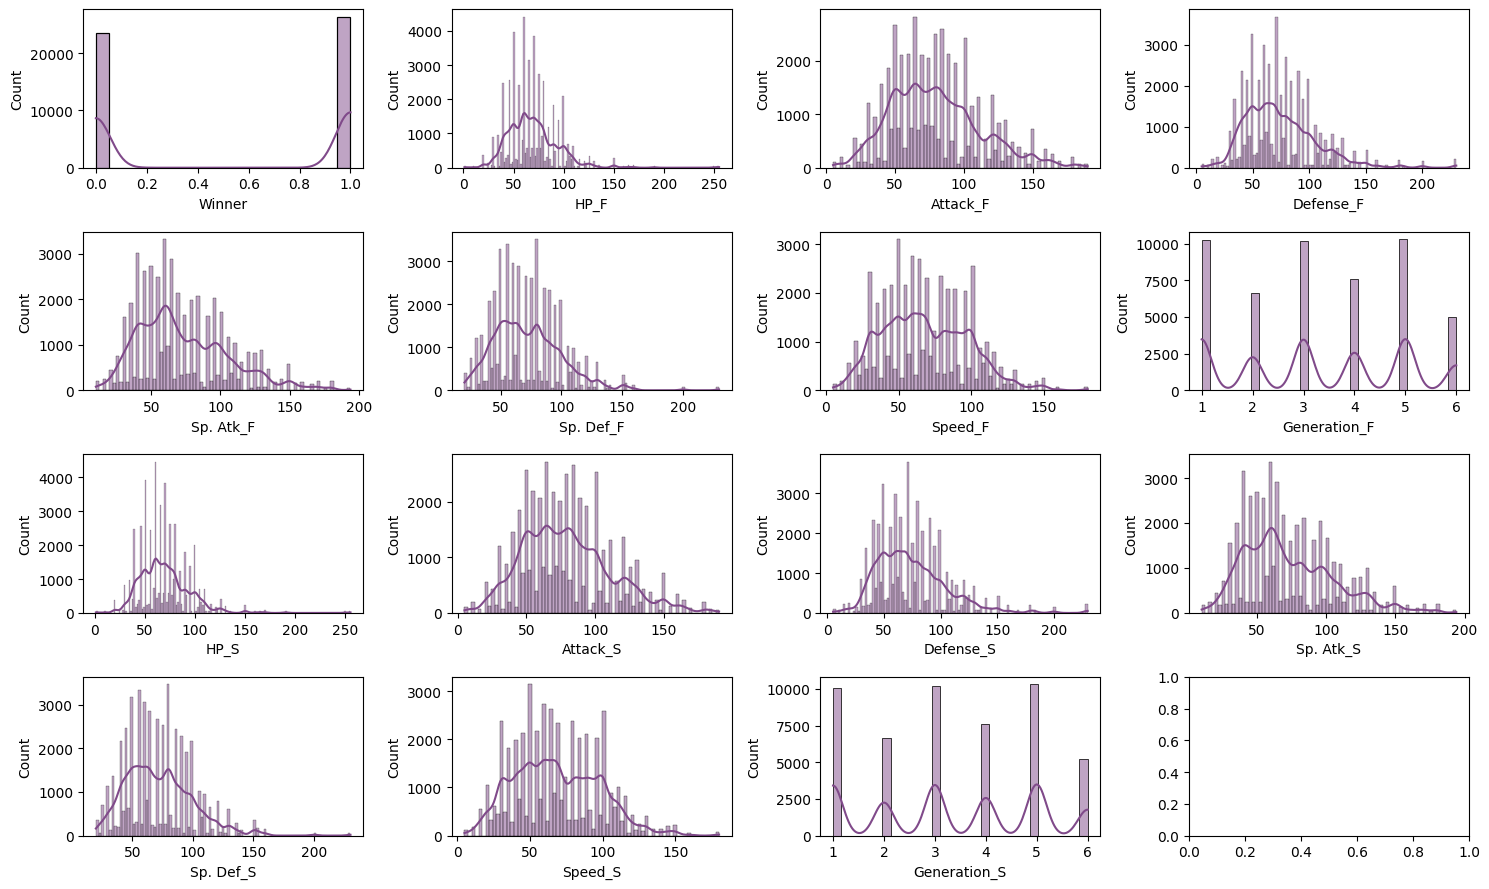

In [42]:
# Estraiamo i dati numerici dal dataframe
numeric_cols: list[str] = df_combats.select_dtypes(include=['int64', 'float64']).columns.tolist()

fig, axes = plt.subplots(4, 4, figsize=(15, 9))
for idx, col in enumerate(numeric_cols):
    ax = axes.flat[idx]
    sb.histplot(df_combats[col], kde=True, ax=ax, color=bar_color)
plt.tight_layout()
plt.show()

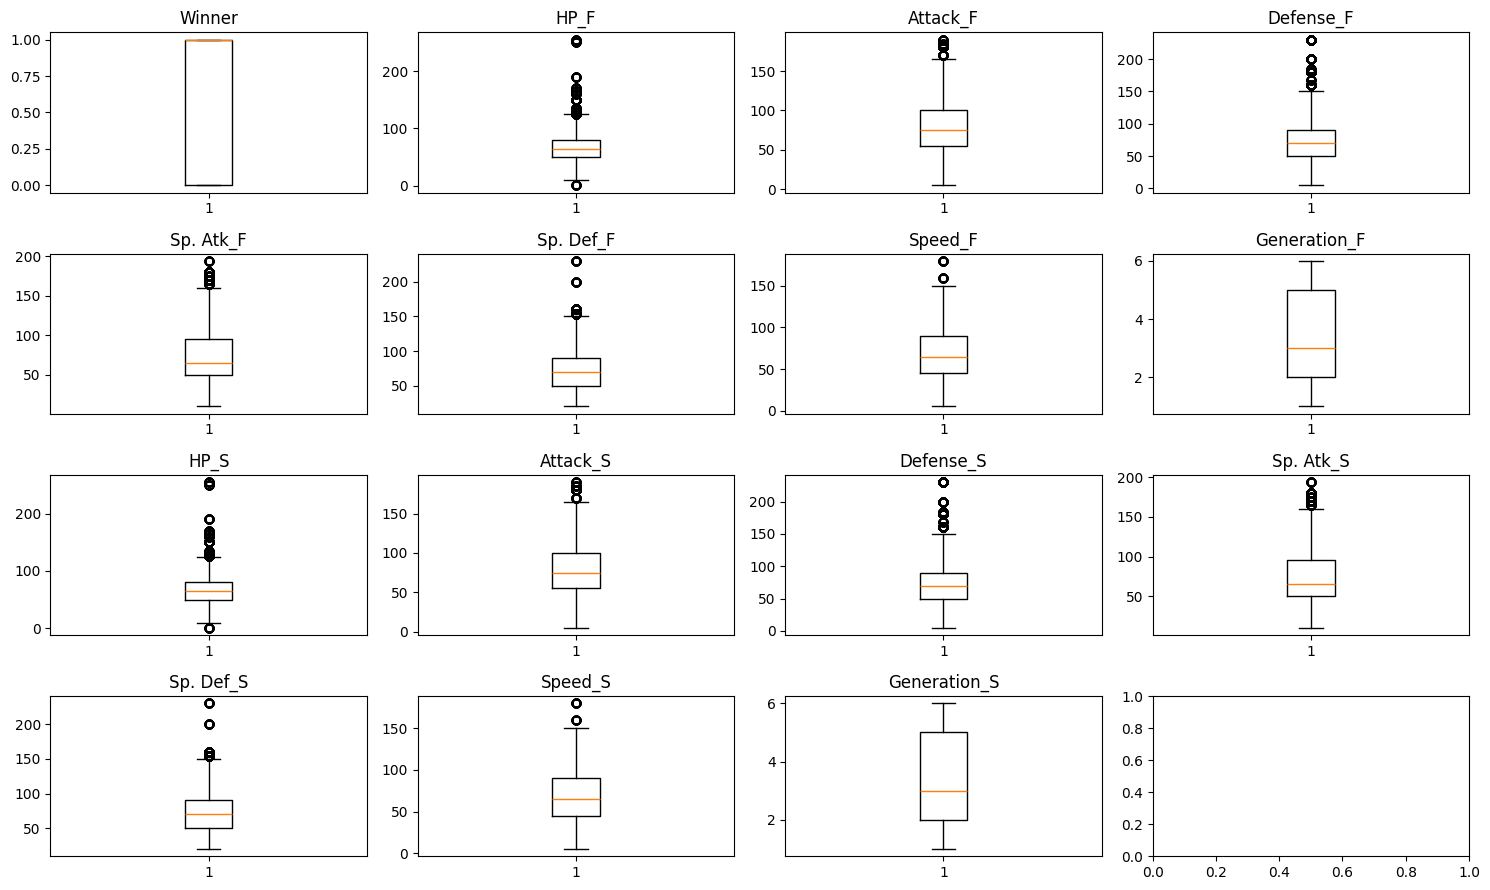

In [43]:
fig, axes = plt.subplots(4, 4, figsize=(15, 9))
for idx, col in enumerate(numeric_cols):
    ax = axes.flat[idx]
    ax.boxplot(df_combats[col])
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Feature Engineering  <a id="feature-engineering"></a>

In [65]:
def function_transformer(dataframe):
   # Funzione per calcolare i moltiplicatori di tipo
   def get_dual_multiplier(df, atk_col, def1_col, def2_col, newcol):
      tmp = df_type_chart.rename(columns={
         'attack': atk_col,
         'defense1': def1_col,
         'defense2': def2_col
      })
      df = df.merge(
         tmp[[atk_col, def1_col, def2_col, 'multiplier']],
         on=[atk_col, def1_col, def2_col],
         how='left'
      ).rename(columns={'multiplier': newcol})
      df[newcol] = df[newcol].fillna(1.0)
      return df
   # Aggiunta dei moltiplicatori di tipo
   dataframe: pd.DataFrame = dataframe.copy()
   dataframe: pd.DataFrame = get_dual_multiplier(dataframe, 'Type 1_F', 'Type 1_S', 'Type 2_S', 'F1_to_S')
   dataframe: pd.DataFrame = get_dual_multiplier(dataframe, 'Type 2_F', 'Type 1_S', 'Type 2_S', 'F2_to_S')
   dataframe: pd.DataFrame = get_dual_multiplier(dataframe, 'Type 1_S', 'Type 1_F', 'Type 2_F', 'S1_to_F')
   dataframe: pd.DataFrame = get_dual_multiplier(dataframe, 'Type 2_S', 'Type 1_F', 'Type 2_F', 'S2_to_F')
   # Rimozione delle colonne di tipo originali
   dataframe.drop(columns=['Type 1_F', 'Type 2_F', 'Type 1_S', 'Type 2_S'], inplace=True)
   # Rimpiazzo delle statistiche con la differenza delle statistiche tra i due pokemon
   stats: list[str] = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
   for stat in stats:
      dataframe[f"delta_{stat}"] = dataframe[f'{stat}_F'] - dataframe[f'{stat}_S']
      dataframe.drop(columns=[f'{stat}_F', f'{stat}_S'], inplace=True)
   # Rimozione delle colonne non necessarie
   return dataframe.drop(columns=['Name_F', 'Name_S', 'Generation_F', 'Generation_S'])

data_transformer: FunctionTransformer = FunctionTransformer(func=function_transformer).set_output(transform="pandas")

## Analisi delle Correlazioni <a id="analisi-delle-correlazioni"></a>

In [66]:
df_combats_with_multiplier: pd.DataFrame = data_transformer.fit_transform(df_combats)

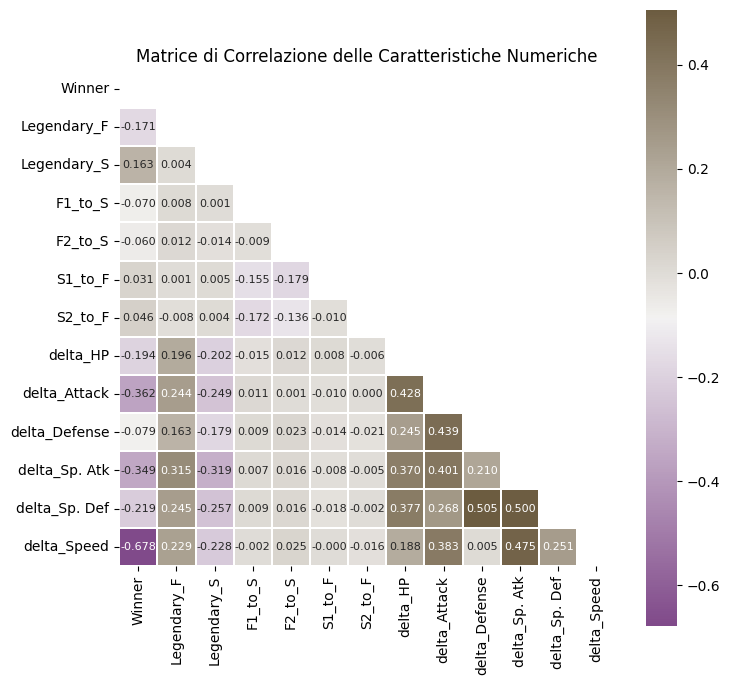

In [67]:
numerical_dataset_correlation: pd.DataFrame = df_combats_with_multiplier.corr()
# Creazione di una maschera per rimuovere valori duplicati nella matrice di correlazione (simmetrica)
mask: np.ndarray = np.zeros_like(numerical_dataset_correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Plotting della matrice di correlazione
plt.figure(figsize=(8, 8))
plt.title("Matrice di Correlazione delle Caratteristiche Numeriche")
sb.heatmap(numerical_dataset_correlation, mask=mask, annot=True, square=True, linewidths=0.1, cmap=cmap, fmt=".3f", annot_kws={"fontsize":8})
plt.show()

<Figure size 1200x1200 with 0 Axes>

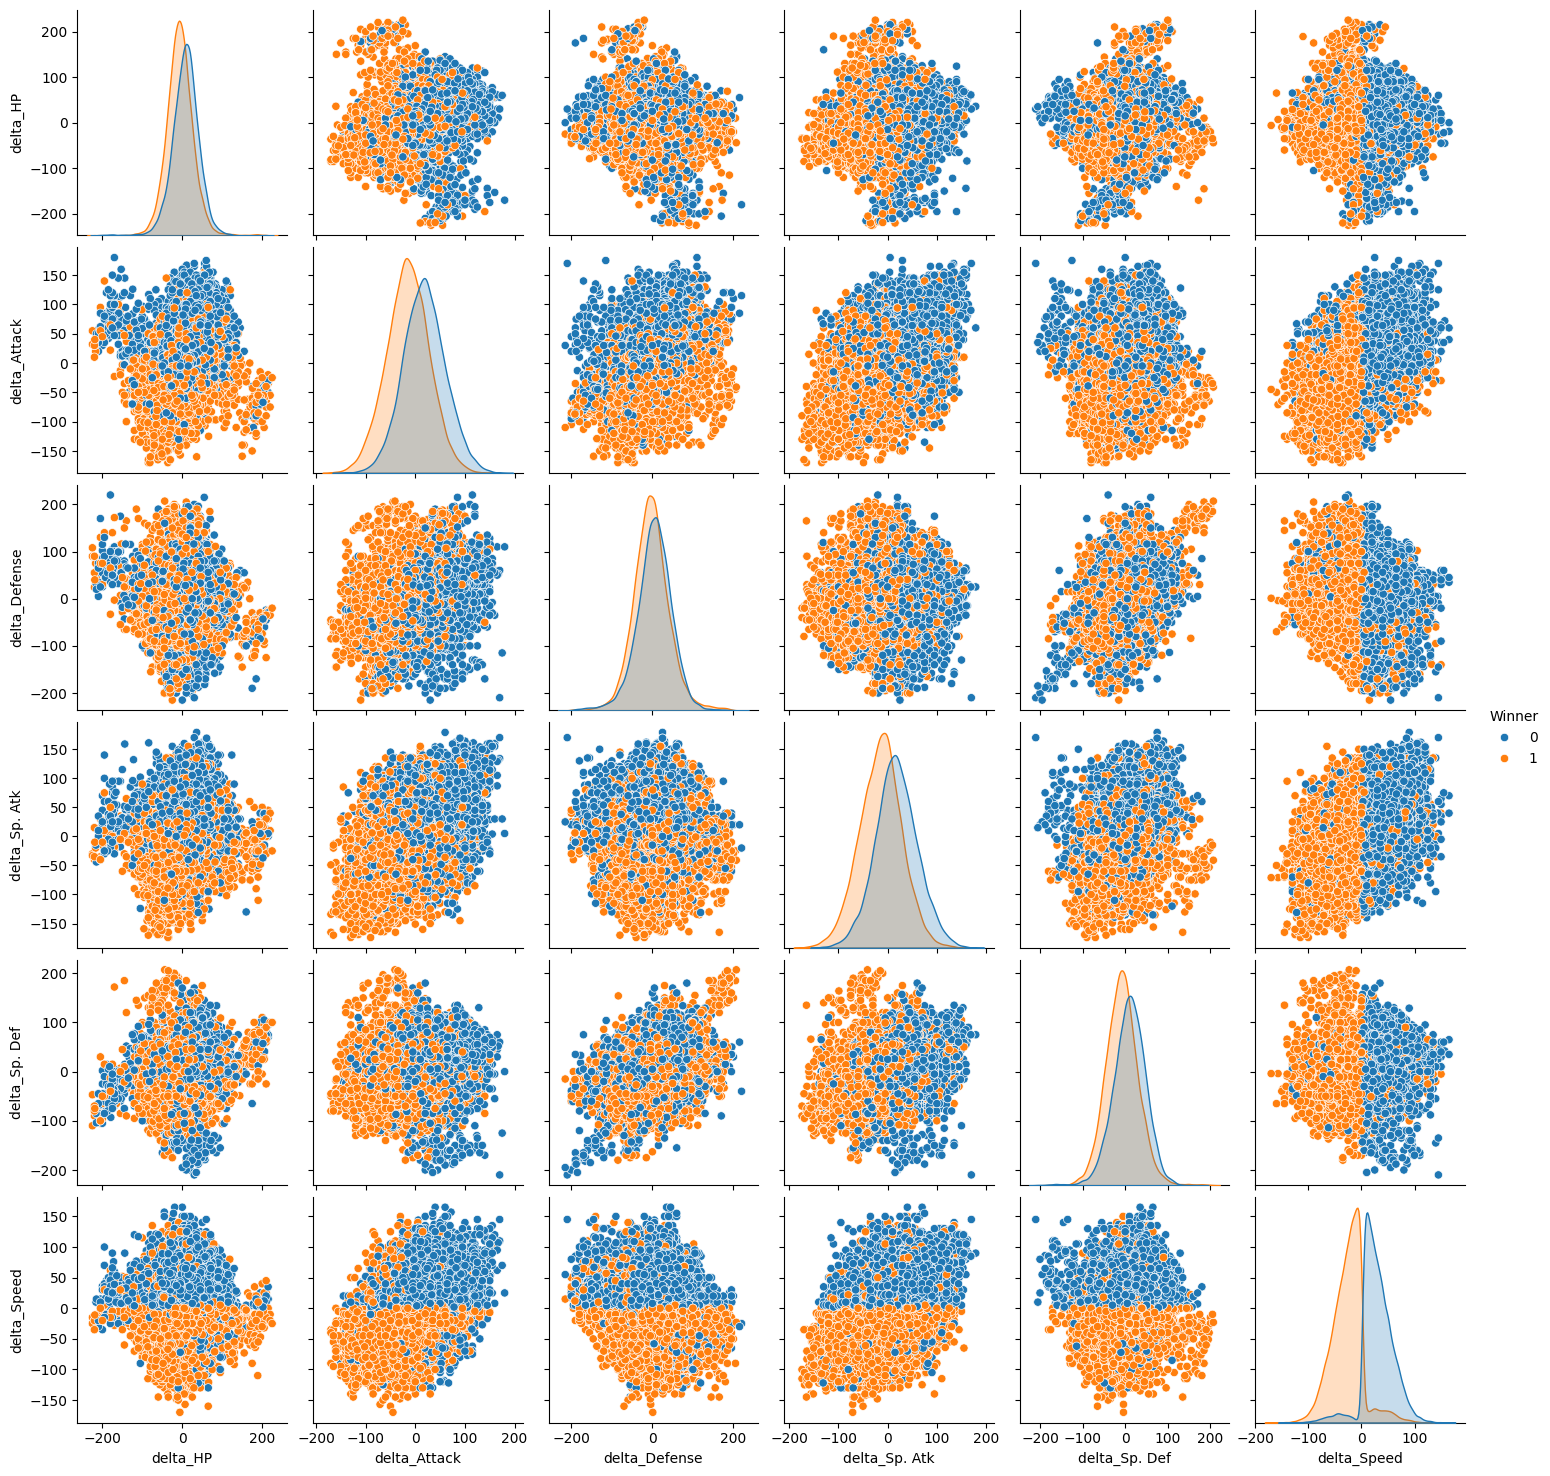

In [28]:
# Plotting di un pairplot per visualizzare le relazioni tra le caratteristiche numeriche e il vincitore
plt.figure(figsize=(12, 12))
sb.pairplot(df_combats_with_multiplier[['delta_HP', 'delta_Attack', 'delta_Defense', 'delta_Sp. Atk', 'delta_Sp. Def', 'delta_Speed', 'Winner']], hue="Winner")
plt.show()

# Addestramento e Tuning dei Modelli <a id="addestramento-e-tuning-dei-modelli"></a>

In [ ]:
# Funzione per addestrare i modelli e calcolare il punteggio
def train_and_score(pipeline, X_train, y_train, X_test, y_test):
    preds = pipeline.predict(X_test)
    return accuracy_score(y_test, preds)

# Creazione del dataset di addestramento e test
y: pd.Series = df_combats['Winner']
X: pd.DataFrame = df_combats.drop(columns=['Winner'])
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VALIDATION_SIZE / (1.0 - TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y_temp
)

In [76]:
# Codifica delle variabili categoriche
# Otteniamo le label delle variabili categoriche
labels_categoriche: list[str] = ['Legendary_F', 'Legendary_S']
# Preprocessing delle variabili categoriche e numeriche
processed_numerical_columns: list[str] = df_combats_with_multiplier.drop(columns=["Winner"]).select_dtypes(include=np.number).columns.tolist();
column_encoder: ColumnTransformer = ColumnTransformer(
    transformers=[
    ("numeric", StandardScaler(), processed_numerical_columns),
    ("categorical", OneHotEncoder(drop='first', sparse_output=False), labels_categoriche),
], sparse_threshold=0.0)

In [77]:
# Modello dummy
dummy_model: Pipeline = Pipeline([
    ('data_transformer', data_transformer),
    ('column_encoder', column_encoder),
    ('classifier', DummyClassifier(strategy='uniform', random_state=RANDOM_STATE))
])

In [78]:
# Modello lineare
linear_model: Pipeline = Pipeline([
    ('data_transformer', data_transformer),
    ('column_encoder', column_encoder),
    ('logistic_l1', LogisticRegression(penalty='l1', solver='liblinear'))
])

In [79]:
# Modello decision tree
decision_tree_model: Pipeline = Pipeline([
    ('data_transformer', data_transformer),
    ('column_encoder', column_encoder),
    ("tree", RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
])

In [80]:
# Modello xgboost
xgboost_model: Pipeline = Pipeline([
   ('data_transformer', data_transformer),
   ('column_encoder', column_encoder),
   ("xgboost", XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE))
])

In [81]:
# Creazione di una griglia di ricerca per ottimizzare i parametri del modello XGBoost
param_grid: dict = {
   'xgboost__n_estimators': [200, 300, 400],
   'xgboost__max_depth': [8, 9, 10],
   'xgboost__learning_rate': [0.05, 0.1, 0.15]
}
grid_xgb: GridSearchCV = GridSearchCV(xgboost_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)
print(f"Best parameters: {grid_xgb.best_params_}")
# Modello xgboost
xgboost_grid_model: Pipeline = grid_xgb.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'xgboost__learning_rate': 0.15, 'xgboost__max_depth': 9, 'xgboost__n_estimators': 300}


In [ ]:
# Addestramento e valutazione dei modelli creati
models: list = [dummy_model, linear_model, decision_tree_model, xgboost_model, xgboost_grid_model]
model_names: list = ['Dummy', 'Logistic Regression', 'Decision Tree', 'XGBoost', 'XGBoost with Grid Search']
# Visualizzazione dei risultati dei modelli
for model, name in zip(models, model_names):
   score: float = train_and_score(model, X_train, y_train, X_test, y_test)
   print(f"{name} score: {score:.4f}")

Dummy score: 0.5035
Logistic Regression score: 0.8762
Decision Tree score: 0.9595
XGBoost score: 0.9616
XGBoost with Grid Search score: 0.9627


In [83]:
# Salvataggio dei modelli
if not os.path.exists('models'):
   os.makedirs('models')

for model, name in zip(models, model_names):
   print(f"Saving model: {name}")
   joblib.dump(model, f'models/{name.replace(" ", "_").lower()}.joblib')

Saving model: Dummy
Saving model: Logistic Regression
Saving model: Decision Tree
Saving model: XGBoost
Saving model: XGBoost with Grid Search


# Valutazione dei Modelli <a id="valutazione-dei-modelli"></a>